In [46]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from os.path import join, expanduser, basename
import os
import geopandas as gpd
import rasterio as rio
from shapely.geometry import box
import matplotlib as mpl
from rasterio.features import dataset_features
from rasterio.plot import show
from shapely.ops import unary_union
from shapely.geometry import Point, Polygon
import folium
from folium import plugins

from invert import invert_sd, epsilon_density
from rio_geom import rio_to_exterior
from folium_vis import add_ee_layer
folium.Map.add_ee_layer = add_ee_layer


In [2]:
import ee

# Initialize the Earth Engine module.
ee.Initialize()

In [17]:
with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

for i in image_fps:
    if i['fp'] == '/bsuscratch/zacharykeskinen/data/uavsar/images/Salt Lake City, UT/stlake_27129_21010-001_21011-012_0007d_s01_L090_01_int_grd/stlake_27129_21010-001_21011-012_0007d_s01_L090HH_01.unw.grd.tiff':
        if basename(i['fp']).split('_')[-2][-2:] == 'HH':
            try:
                fp = i['fp']
                with rio.open(fp) as src:
                    bounds = src.bounds
                geom = ee.Geometry.BBox(*bounds)
                df = pd.read_csv(i['ann'], index_col = [0])
                s = pd.to_datetime(df.loc['value','start time of acquisition for pass 1']).tz_localize(None)
                e = pd.to_datetime(df.loc['value','start time of acquisition for pass 2']).tz_localize(None)
                cor = i['cor']
                snow_cover = ee.ImageCollection("MODIS/006/MOD10A1").select('NDSI_Snow_Cover').filterDate(s,e).mean().clip(geom)
                sc_masked = snow_cover.updateMask(snow_cover.lte(10))
                mask_count = sc_masked.reduceRegion(**{'reducer': ee.Reducer.count(), 'scale' : 500}).getInfo()['NDSI_Snow_Cover']
                full_count = snow_cover.reduceRegion(**{'reducer': ee.Reducer.count(), 'scale' : 500}).getInfo()['NDSI_Snow_Cover']
                print(f'Pixels below 0.1 {mask_count/full_count} for total of {mask_count}')
            except ee.ee_exception.EEException as e:
                print(e)

Pixels below 0.1 0.03009305088101366 for total of 152


In [16]:
snow_cover

In [53]:
vectors = snow_cover.gt(10).reduceToVectors(scale=500).filterMetadata('label','equals',0)

In [52]:
vectors.filterMetadata('label','equals',0).first().getInfo()

{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-111.78186237941266, 40.49156143168744], [-111.77737080299207, 40.49156143168744], [-111.77737080299207, 40.49605300810803], [-111.78186237941266, 40.49605300810803], [-111.78186237941266, 40.49156143168744]]]}, 'id': '-24887+9015', 'properties': {'count': 1, 'label': 0}}

In [54]:
# This function computes the feature's geometry area and adds it as a property.
def addArea(feature):
  return feature.set({'areaHa': feature.geometry().area(10).divide(100 * 100)})

In [55]:
# Map the area getting function over the FeatureCollection.
areaAdded = vectors.map(addArea)

In [56]:
f = areaAdded.limit(1, 'areaHa', False)

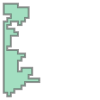

In [57]:
p = Polygon(f.first().geometry().coordinates().getInfo()[0])
p

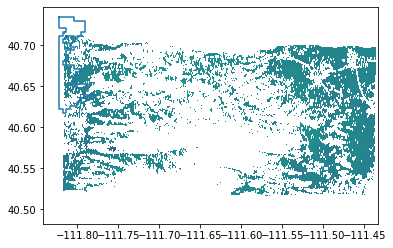

In [58]:
f, ax = plt.subplots()
with rio.open(fp) as src:
    show(src, ax = ax)
x,y = p.exterior.xy
plt.plot(x,y)

In [59]:
from rasterstats import zonal_stats

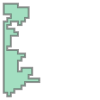

In [117]:
f = areaAdded.sort('areaHa', False)
f = f.filterMetadata('areaHa','greater_than',100)
p = Polygon(f.first().geometry().coordinates().getInfo()[0])
p

In [123]:
f.toList(f.size().getInfo())

In [116]:
f = f.toList(f.size().getInfo())
p = Polygon(f.get(0).getInfo()['geometry']['coordinates'][0])
p

AttributeError: 'List' object has no attribute 'toList'

In [ ]:
with rio.open(fp) as src:
    affine = src.transform
    array = src.read(1)
    df_zonal_stats = pd.DataFrame(zonal_stats(gdf, array, affine=affine))

# adding statistics back to original GeoDataFrame
gdf2 = pd.concat([gdf, df_zonal_stats], axis=1) 


In [70]:
from shapely.geometry import mapping
geoms = [mapping(p)]

In [71]:
from rasterio.mask import mask
with rio.open(fp) as src:
     out_image, out_transform = mask(src, geoms, crop=True)

In [74]:
np.nanmean(out_image[0])

0.014349021